# Task 7 Study an integral
## Subtask 1: Take some "interesting" function and compute its integral over some segment. Compute the value analytically. 

![image](Task_7/integral.jpg)

## Subtask 2: Compute the integral using trapezoidal rule

In [25]:
import math
import numpy as np

def calculate_integral(start_val, end_val, steps, err_Estim = False):
    
    x_0 = start_val # start value of the interval
    x_1 = end_val # stop value of the intherval
    steps = steps # the number of steps on the interval

    # integral
    x = np.linspace(x_0, x_1, steps) # small step
    y = np.exp(x) * np.cos(x) # function
    I_1n = np.trapz(y = y, x = x, axis = 0) # trapezoidal integration
    
    if err_Estim == True:
        # for error estimation
        x = np.linspace(x_0, x_1, int(steps / 2)) # long step
        y = np.exp(x) * np.cos(x) # function
        I_2n = np.trapz(y = y, x = x, axis = 0) # trapezoidal integration

        # we can estimate error using double calculation: I_1n, I_2n
        # error estimation: ERR <= |I_2n - I_1n| / 3
        err = abs(I_2n - I_1n) / 3
        return I_1n, err
    else:
        return I_1n

result = calculate_integral(start_val = 0.0 * math.pi, end_val = 2.0 * math.pi, steps = 1001, err_Estim = True)
#print('Integral value:', result)
print('Integral value:', result[0], 'Error estimation:', result[1])

Integral value: 267.24758617176144 Error estimation: 0.0017678251149580622


## Subtask 3: Parallelize using MPI. You should be able to choose any number of MPI processes regardless of the number of discretization points.

In [26]:
%%writefile integral1.py

from mpi4py import MPI
import math
import numpy as np

def calculate_integral(start_val, end_val, steps, n_proc, rank, err_Estim = False):
    x_0 = start_val
    x_1 = end_val
    step = x_1 / n_proc
    points_X = steps
    
    # if points_X / n_proc is not integer
    blocks_X = int(points_X / n_proc) # points of x axis
    remainder = points_X % n_proc # remainder for the last block
    add = 0 # addition of the last block
    if rank == n_proc-1: # if current process is last
        add = remainder # addition is equal to remainder
        
    # integral
    x = np.linspace(x_0 + step * rank, x_0 + step * (rank + 1), add + blocks_X) # small step
    y = np.exp(x) * np.cos(x) # function
    I_1n = np.trapz(y = y, x = x, axis = 0) # trapezoidal integration
    
    if err_Estim:
        # for error estimation
        x = np.linspace(x_0 + step * rank, x_0 + step * (rank + 1), add + int(steps / (2 * n_proc))) # long step
        y = np.exp(x) * np.cos(x) # function
        I_2n = np.trapz(y = y, x = x, axis = 0) # trapezoidal integration

        # we can estimate error using double calculation: I_1n, I_2n
        # error estimation: ERR <= |I_2n - I_1n| / 3
        err = abs(I_2n - I_1n) / 3

        # print('Integral value:  ', I_1n)
        # print('Error estimation:', err)
        return I_1n, err
    else:
        return I_1n

comm = MPI.COMM_WORLD
n_proc = comm.Get_size() # processors
rank = comm.Get_rank() # current rank

if rank == 0:
    print('nprocs = ', n_proc)
    t0 = MPI.Wtime() # measure start time
    
#n = comm.bcast(n, root=0)
integral_part = calculate_integral(start_val = 0, end_val = 2 * math.pi, steps = 10000000, n_proc = n_proc, rank = rank, err_Estim = False) # calculate integral part with current rank
integral = comm.reduce(integral_part, op = MPI.SUM, root = 0) # accumulate all values to get final result

if rank == 0:
    print ('integral = ', integral)
    totalTime =  MPI.Wtime() - t0
    print('time = ', np.round((totalTime),4) * 1000, 'mSec')

    np.savez('Task_5/example_'+str(n_proc), totalTime = np.round((totalTime),4) * 1000)

Overwriting integral1.py


In [27]:
!mpiexec -n 1 python integral1.py

nprocs =  1
integral =  267.2458277623998
time =  230.7 mSec


## Subtask 4: Plot the speedup vs number of processors

In [28]:
import subprocess
times = []
for i in range(1,10,1):
    o = subprocess.run(["mpiexec","-n", str(i), "python", "integral1.py"],         
        universal_newlines=True,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE)
    res = list(o.stdout.strip().split(' '))
    times.append(res[9])
times = list(map(float, times))

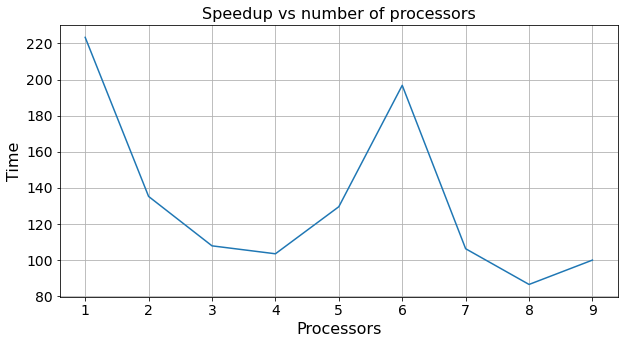

In [29]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.title('Speedup vs number of processors', fontsize=16)
plt.ylabel('Time', fontsize=16)
plt.xlabel('Processors', fontsize=16)
plt.xticks(np.arange(0, 11), np.arange(1, 12), fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
#x = np.arange(1+len(times))
plt.plot(np.array(times))

## Subtask 5: Plot integration error vs the discretization step

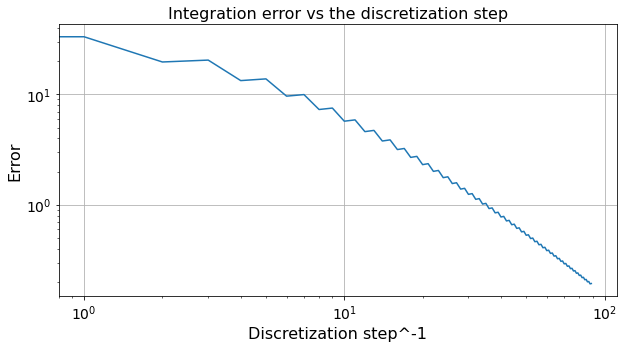

In [30]:
a = []
for i in range(10,100,1):
    result = calculate_integral(start_val = 0.0 * math.pi, end_val = 2.0 * math.pi, steps = i, err_Estim = True)
    a.append(result[1])

plt.figure(figsize=(10, 5))
plt.title('Integration error vs the discretization step', fontsize=16)
plt.ylabel('Error', fontsize=16)
plt.xlabel('Discretization step^-1', fontsize=16)
plt.xticks(np.arange(0, 90,10), np.arange(10, 100,10), fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.loglog(a)